data_firefox

In [1]:
import pandas as pd
import ray
import swifter

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from rapidfuzz import process

In [11]:
ray.shutdown()

In [376]:
ray.init()

2022-09-07 07:49:31,101	INFO services.py:1456 -- View the Ray dashboard at http://127.0.0.1:8265


RayContext(dashboard_url='127.0.0.1:8265', python_version='3.9.12', ray_version='1.12.0', ray_commit='f18fc31c7562990955556899090f8e8656b48d2d', address_info={'node_ip_address': '127.0.0.1', 'raylet_ip_address': '127.0.0.1', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-09-07_07-49-28_098649_49088/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-09-07_07-49-28_098649_49088/sockets/raylet', 'webui_url': '127.0.0.1:8265', 'session_dir': '/tmp/ray/session_2022-09-07_07-49-28_098649_49088', 'metrics_export_port': 65056, 'gcs_address': '127.0.0.1:64182', 'address': '127.0.0.1:64182', 'node_id': '8bb8a461935b0c06f93cb3b13d103f6cea8eb261fd7d510678262c48'})

In [2]:
%%time
data_firefox = pd.read_parquet("../data/interim/firefox/08_12_2022/http.0.parquet.gzip")

CPU times: user 6.69 s, sys: 1.32 s, total: 8 s
Wall time: 8.04 s


In [3]:
%%time
data_firefox

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 3.1 µs


,easylist,easyprivacy,hostname,pathname,filetype,filename,protocol,query,date,content-type,...,x-namu-source,varnish-cache,x-bf-cdn-url,x-username,x-domain,x-dashboard,x-adwsegments,x-render-time,x-buzzfeed-infra-jobs,x-imp
0,False,False,vuukle.com,/a3a95d10e1d03fe77d6b.png,png,a3a95d10e1d03fe77d6b.png,https:,[],"fri, 12 aug 2022 22:10:52 gmt",image/webp,...,None,None,None,None,None,None,None,None,None,None
1,False,False,vuukle.com,/589.1b85456a4e062e8d6232.js,js,589.1b85456a4e062e8d6232.js,https:,[],"fri, 12 aug 2022 22:10:52 gmt",application/javascript,...,None,None,None,None,None,None,None,None,None,None
2,False,False,vuukle.com,/29eab20501ed73f16eba.jpg,jpg,29eab20501ed73f16eba.jpg,https:,[],"fri, 12 aug 2022 22:10:52 gmt",image/webp,...,None,None,None,None,None,None,None,None,None,None
3,False,False,vuukle.com,/22ab1ea08fc1962409f1.png,png,22ab1ea08fc1962409f1.png,https:,[],"fri, 12 aug 2022 22:10:52 gmt",image/webp,...,None,None,None,None,None,None,None,None,None,None
4,False,False,cookie-cdn.cookiepro.com,/scripttemplates/6.19.0/otTCF.js,js,otTCF.js,https:,[],"fri, 12 aug 2022 22:10:52 gmt",application/javascript,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164001,False,True,www.google-analytics.com,/plugins/ua/ec.js,js,ec.js,https:,[],"fri, 12 aug 2022 11:50:11 gmt",text/javascript,...,None,None,None,None,None,None,None,None,None,None
164002,False,False,cache.img.gmo.jp,/gmo/header/en/img/logo-gmo26th-en.svg,svg,logo-gmo26th-en.svg,https:,"[[1652418682, ]]","fri, 12 aug 2022 11:53:34 gmt",image/svg+xml,...,None,None,None,None,None,None,None,None,None,None
164003,False,True,www.google-analytics.com,/j/collect,/j/collect,collect,https:,"[[v, 1], [_v, j96], [a, 1066606414], [t, pagev...","fri, 12 aug 2022 11:53:34 gmt",text/plain,...,None,None,None,None,None,None,None,None,None,None
164004,False,False,cache.img.gmo.jp,/gmo/header/en/img/logo-sdgs-en.svg,svg,logo-sdgs-en.svg,https:,"[[1652418682, ]]","fri, 12 aug 2022 11:53:34 gmt",image/svg+xml,...,None,None,None,None,None,None,None,None,None,None


In [35]:
data_firefox.info(memory_usage="deep")

# 14GB -> 763MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167558 entries, 0 to 167557
Columns: 3921 entries, easylist to mid
dtypes: Int64(602), bool(2), category(3316), object(1)
memory usage: 1.5 GB


In [5]:
data_firefox.dtypes

easylist                 bool
easyprivacy              bool
hostname               object
pathname               object
filetype               object
                        ...  
x-amp-published        object
x-amp-source-height    object
x-amp-source-width     object
x-amp-srv              object
port                   object
Length: 4259, dtype: object

data_firefox

### Check Tracking Classification and Create New Label Column

In [4]:
data_firefox["easylist"] = data_firefox["easylist"].astype(np.int32)
data_firefox["easyprivacy"] = data_firefox["easyprivacy"].astype(np.int32)

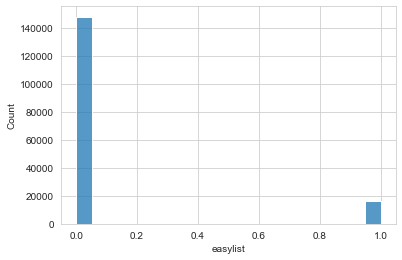

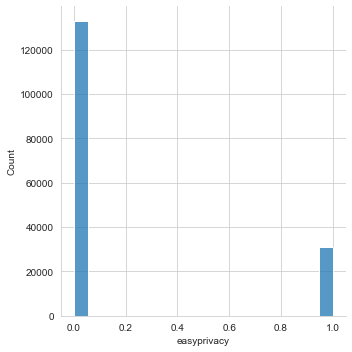

In [5]:
sns.histplot(data_firefox, x="easylist")
sns.displot(data_firefox, x="easyprivacy")

In [6]:
data_firefox["tracker"] = np.where(
    np.logical_or(data_firefox.easylist == 1, data_firefox.easyprivacy == 1), 1, 0
)
data_firefox["tracker"] = data_firefox["tracker"].astype(np.int32)

In [7]:
data_firefox.drop(["easylist", "easyprivacy"], axis=1, inplace=True)

<AxesSubplot:xlabel='tracker', ylabel='Count'>

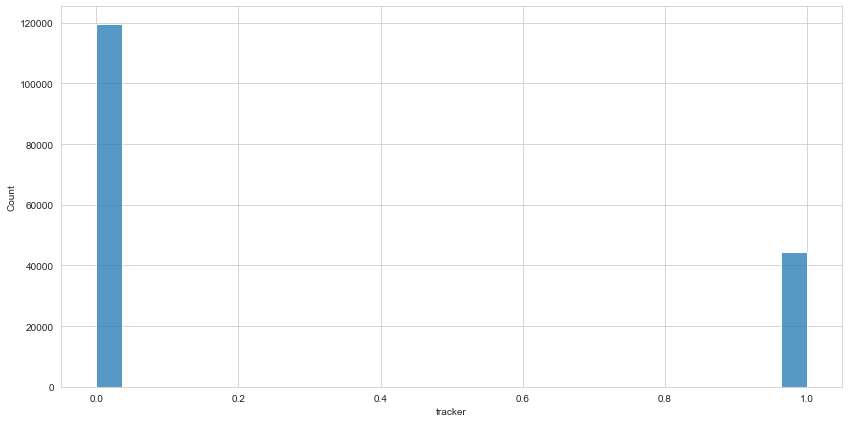

In [8]:
plt.figure(figsize=(14, 7))
sns.histplot(data_firefox, x="tracker")

In [14]:
data_firefox['tracker'].value_counts()

class_0 = len(data_firefox[data_firefox['tracker'] == 0]) / 10000
class_1 = len(data_firefox[data_firefox['tracker'] == 1]) / 10000

class_distribution_ratio = class_1 / class_0
print(class_distribution_ratio)
print(class_0, class_1)

0.006503172348216864
17.6683 0.1149


### Check Column Name Similarity

In [17]:
def new_fuzzy_string_matching_for_column(col_name, col_values):
    result = pd.DataFrame(
        process.extract(
            col_name, col_values, processor=None, score_cutoff=80, limit=100
        ),
        columns=["fuzzy_match", "w_ratio", "index"],
    )
    result["col_name"] = col_name
    return result

In [18]:
%%time
data_firefox_column_values = data_firefox.columns.values[6:-1].tolist()

match_firefox = [
    new_fuzzy_string_matching_for_column(j, data_firefox_column_values[i + 1 :])
    for i, j in enumerate(data_firefox_column_values)
    if i != len(data_firefox_column_values) - 1
]

match2_firefox = pd.concat(match_firefox, ignore_index=True)
print(match2_firefox)

                 fuzzy_match    w_ratio index            col_name
0            x-database-date       90.0   365                date
1                x-save-date       90.0   563                date
2            x-rum-validated       90.0   612                date
3            x-response-date       90.0   817                date
4            x-snapshot-date       90.0  1085                date
...                      ...        ...   ...                 ...
15683  x-nf-stargate-version  81.081081     5    x-nf-ats-version
15684       x-nf-srv-version  82.352941     0  x-nf-proxy-version
15685  x-nf-stargate-version  81.081081     0    x-nf-srv-version
15686         x-fastly-stale  84.615385     0        x-fastly-ttl
15687              x-say-ttl  85.714286     1        x-saycdn-ttl

[15688 rows x 4 columns]
CPU times: user 10.4 s, sys: 50.2 ms, total: 10.4 s
Wall time: 10.5 s


In [10]:
def find_cols_with_similar_values(fuzzy_match, column):
    value_fuzzy = set(data_firefox[fuzzy_match].values)
    value_column = set(data_firefox[column].values)

    value_fuzzy.remove(None)
    value_column.remove(None)

    if (len([True for i in value_fuzzy if i in value_column]) / len(value_fuzzy)) > 0.5:
        return fuzzy_match, column
    else:
        return None

In [11]:
def select_similar_columns(fuzzy_match, column):
    row = match2_firefox.loc[(match2_firefox['fuzzy_match'] == fuzzy_match) & (match2_firefox['col_name'] == column)]
    index = row.index[0]
    match2_firefox.drop(index, inplace=True)
    return row

In [12]:
%%time
result = [find_cols_with_similar_values(col, col2) for col, col2 in zip(match2_firefox['fuzzy_match'], match2_firefox['col_name'])]

CPU times: user 1min 35s, sys: 297 ms, total: 1min 36s
Wall time: 1min 36s


In [13]:
similar_values = [select_similar_columns(col[0], col[1]) for col in result if col is not None]
similar_values = pd.concat(similar_values, ignore_index=True)
similar_values

,fuzzy_match,w_ratio,index,col_name
0,x-kw-date,90.0,2041,date
1,x-render-date,90.0,2591,date
2,x-kw-expires,90.0,2041,expires
3,expries,85.714286,3537,expires
4,cache-conrol,96.0,3329,cache-control
...,...,...,...,...
1113,x-debug-v-x-fazpay-jwt-payload-claim-premium,82.051282,0,x-debug-v-x-fazpay-jwt-payload-raw
1114,j-cache,83.076923,136,x-usf-cache
1115,x-tst-host,83.333333,0,x-tst-host-cap
1116,dont-retry,90.0,0,x-kontur-dont-retry


In [14]:
def merge_similar_columns2(fuzzy_match, col_name):
    boolean_mask = data_firefox[fuzzy_match].notnull()
    new_values = data_firefox[boolean_mask][fuzzy_match].to_numpy()
    indices_fuzzy_matches = data_firefox.index[boolean_mask].tolist()

    current_values = data_firefox[col_name].to_numpy()
    np.put(current_values, indices_fuzzy_matches, new_values)

In [15]:
%%time
similar_values.apply(lambda x: merge_similar_columns2(x['fuzzy_match'], x['col_name']), axis=1)

CPU times: user 7.91 s, sys: 309 ms, total: 8.22 s
Wall time: 8.27 s


0       None
1       None
2       None
3       None
4       None
        ... 
1113    None
1114    None
1115    None
1116    None
1117    None
Length: 1118, dtype: object

In [16]:
columns_to_remove = list(set(similar_values.fuzzy_match.values.tolist()))
data_firefox.drop(columns_to_remove, axis=1, inplace=True)

data_firefox

In [25]:
%matplotlib inline
plt.figure(figsize=(20, 10))

ct_values = data_firefox[["content-type", "tracker"]].dropna()

ct_values

data_firefox[['content-type', 'tracker']].value_counts().head(20)

content-type                           tracker
image/jpeg                             0          28973
application/javascript                 0          22902
image/png                              0          22027
image/webp                             0          15905
image/svg+xml                          0          13599
text/css                               0          11109
application/javascript; charset=utf-8  0           8609
application/x-javascript               0           5867
font/woff2                             0           4444
application/json                       0           4084
text/html; charset=utf-8               0           3956
application/json; charset=utf-8        0           3542
text/javascript                        0           3019
text/css; charset=utf-8                0           2977
text/javascript; charset=utf-8         0           2338
image/gif                              0           1895
application/octet-stream               0           1727
t

<Figure size 1440x720 with 0 Axes>

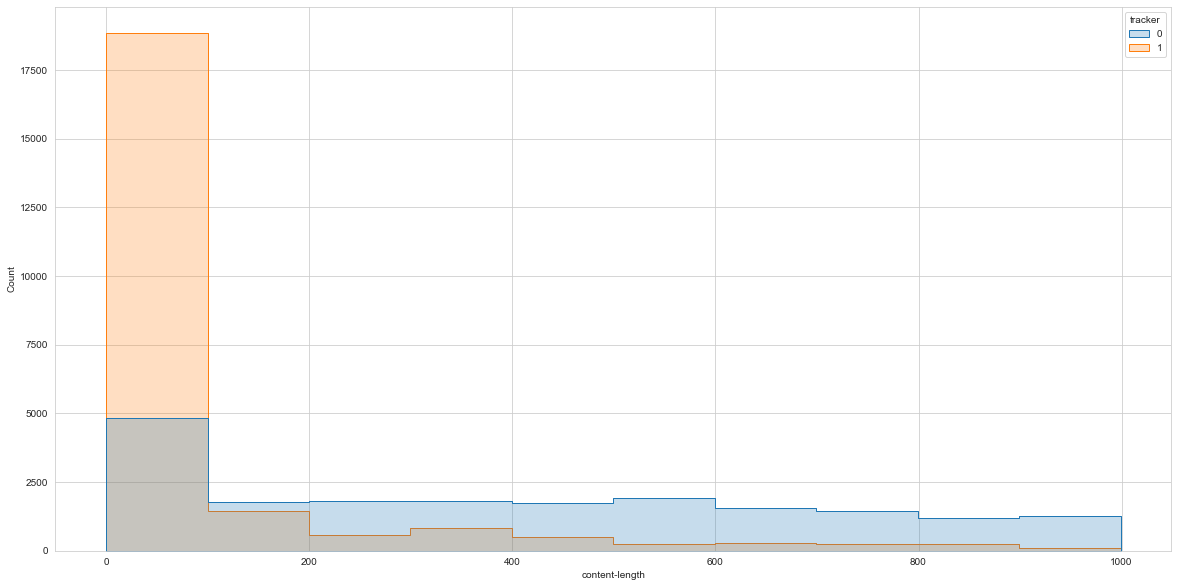

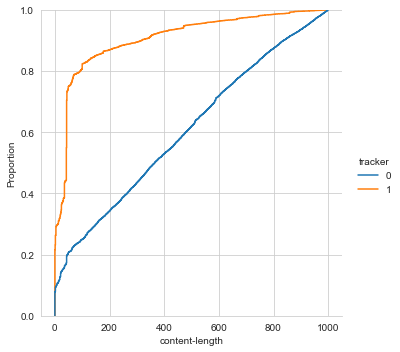

In [19]:
%matplotlib inline
plt.figure(figsize=(20, 10))
cl_values = data_firefox[["content-length", "tracker"]].dropna().astype('Int32')
sns.histplot(cl_values[cl_values['content-length'] < 1000], bins=10, x="content-length", hue='tracker', element='step')

sns.displot(cl_values[cl_values['content-length'] < 1000], x="content-length", kind='ecdf', hue='tracker')
plt.show()

### Explore Distributions

Text(0.5, 1.0, 'Distribution of #NAs Across All Columns')

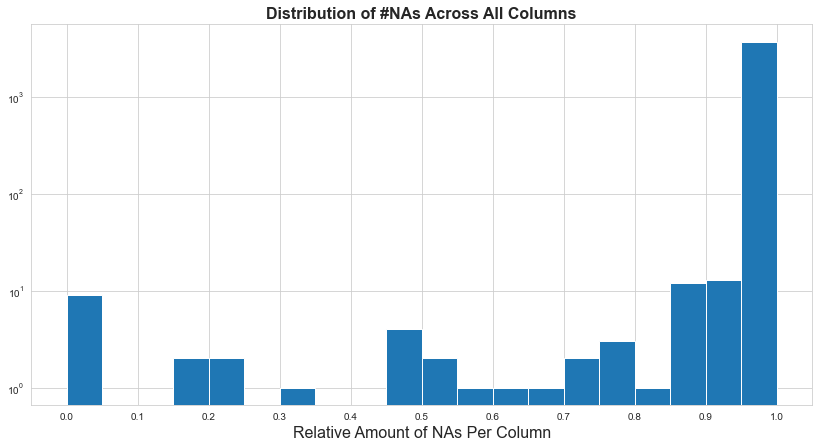

In [21]:
relative_na_per_col = pd.DataFrame((data_firefox.isna().sum() / len(data_firefox)), columns=["summary"])

plt.figure(figsize=(14, 7))
plt.hist(relative_na_per_col["summary"], log=True, bins=20)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlabel("Relative Amount of NAs Per Column", fontdict={"fontsize": 16})
plt.title("Distribution of #NAs Across All Columns", fontsize=16, fontweight="bold")

Text(0.5, 1.0, 'Distribution of #Values Across All Columns')

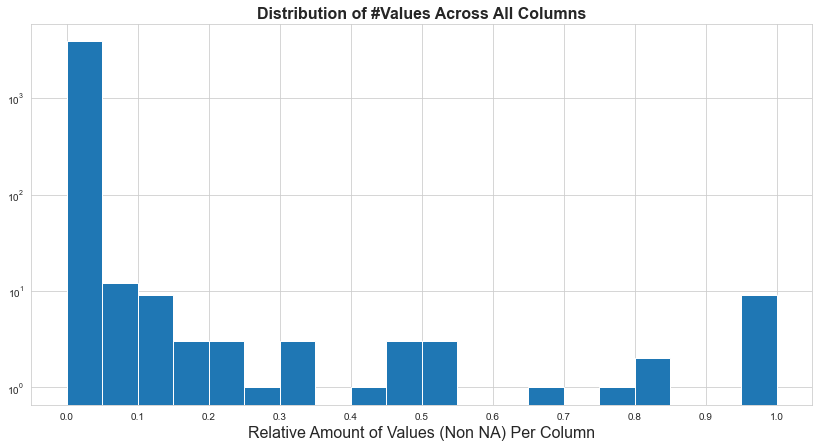

In [579]:
relative_values_per_col = pd.DataFrame((data_firefox.count() / len(data_firefox)), columns=["summary"])

plt.figure(figsize=(14, 7))
plt.hist(relative_values_per_col["summary"], log=True, bins=20)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlabel("Relative Amount of Values (Non NA) Per Column", fontdict={"fontsize": 16})
plt.title("Distribution of #Values Across All Columns", fontsize=16, fontweight="bold")

In [139]:
rel_frequency_per_col = (
    data_firefox.groupby("tracker").count() / data_firefox.groupby("tracker").count().sum()
)
rel_frequency_per_col.transpose()

tracker,0,1
hostname,0.728655,0.271345
pathname,0.728655,0.271345
filetype,0.728655,0.271345
filename,0.728655,0.271345
protocol,0.728655,0.271345
...,...,...
x-client-geo-city,1.000000,0.000000
x-client-geo-region,1.000000,0.000000
x-client-geo-metrocode,1.000000,0.000000
x-client-geo-zip,1.000000,0.000000


In [111]:
columns_with_more_trackers = rel_frequency_per_col.iloc[
    :, np.where([rel_frequency_per_col.iloc[1, :] > 0.5])[1]
].transpose()
columns_with_more_trackers["total_frequency"] = (
    data_firefox[columns_with_more_trackers.index.values].count().values
)
columns_with_more_trackers["total_nas"] = (
    data_firefox[columns_with_more_trackers.index.values].isna().sum().values
)
columns_with_more_trackers["ratio_value_total"] = columns_with_more_trackers[
    "total_frequency"
] / len(data_firefox)

columns_with_more_trackers.sort_values(by=["total_frequency"], ascending=False)

tracker,0,1,total_frequency,total_nas,ratio_value_total
alt-svc,0.487842,0.512158,37713,129845,0.225074
cross-origin-resource-policy,0.316124,0.683876,25936,141622,0.154788
access-control-allow-credentials,0.467669,0.532331,22873,144685,0.136508
pragma,0.267543,0.732457,20550,147008,0.122644
p3p,0.193632,0.806368,15483,152075,0.092404
...,...,...,...,...,...
x-marintrackerversion,0.000000,1.000000,1,167557,0.000006
tk,0.000000,1.000000,1,167557,0.000006
disposition,0.000000,1.000000,1,167557,0.000006
x-onead-guid,0.000000,1.000000,1,167557,0.000006


In [112]:
columns_with_more_non_trackers = rel_frequency_per_col.iloc[
    :, np.where([rel_frequency_per_col.iloc[0, :] > 0.5])[1]
].transpose()
columns_with_more_non_trackers["total_frequency"] = (
    data_firefox[columns_with_more_non_trackers.index.values].count().values
)
columns_with_more_non_trackers["total_nas"] = (
    data_firefox[columns_with_more_non_trackers.index.values].isna().sum().values
)
columns_with_more_non_trackers["ratio_value_total"] = columns_with_more_non_trackers[
    "total_frequency"
] / len(data_firefox)

columns_with_more_non_trackers.sort_values(by=["total_frequency"], ascending=False)

tracker,0,1,total_frequency,total_nas,ratio_value_total
hostname,0.728655,0.271345,167558,0,1.000000
protocol,0.728655,0.271345,167558,0,1.000000
query,0.728655,0.271345,167558,0,1.000000
pathname,0.728655,0.271345,167558,0,1.000000
filename,0.728655,0.271345,167558,0,1.000000
...,...,...,...,...,...
x-request-minified,1.000000,0.000000,1,167557,0.000006
x-smart-cache,1.000000,0.000000,1,167557,0.000006
x-smart-cache-id,1.000000,0.000000,1,167557,0.000006
x-smart-cache-ttl,1.000000,0.000000,1,167557,0.000006


(array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

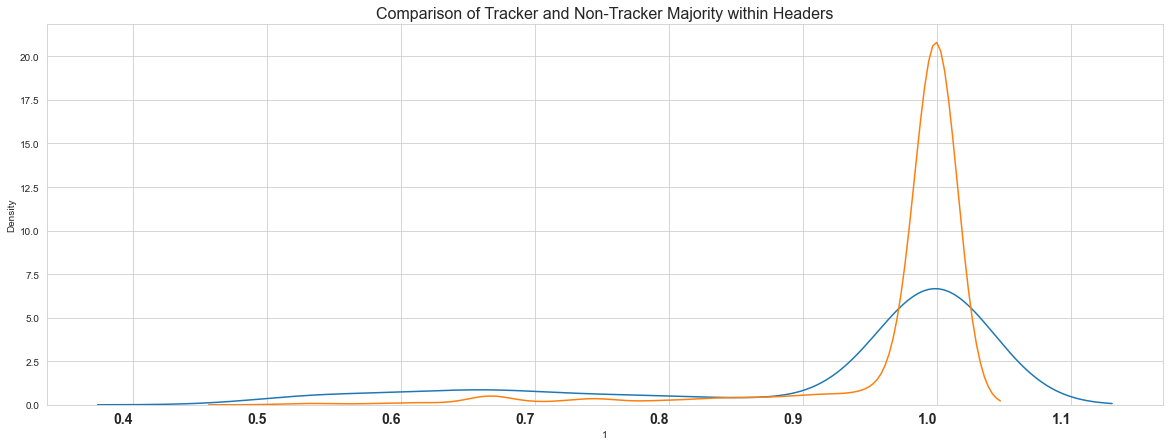

In [115]:
plt.figure(figsize=(20, 7))
sns.kdeplot(columns_with_more_trackers.iloc[:, 1])
sns.kdeplot(columns_with_more_non_trackers.iloc[:, 0])
plt.title(
    "Comparison of Tracker and Non-Tracker Majority within Headers",
    fontdict={"fontsize": 16},
)
plt.xticks(fontsize=14, fontweight="bold", ha="right")

Text(0.5, 0.98, 'Relative Frequency per Column by Tracker Classification')

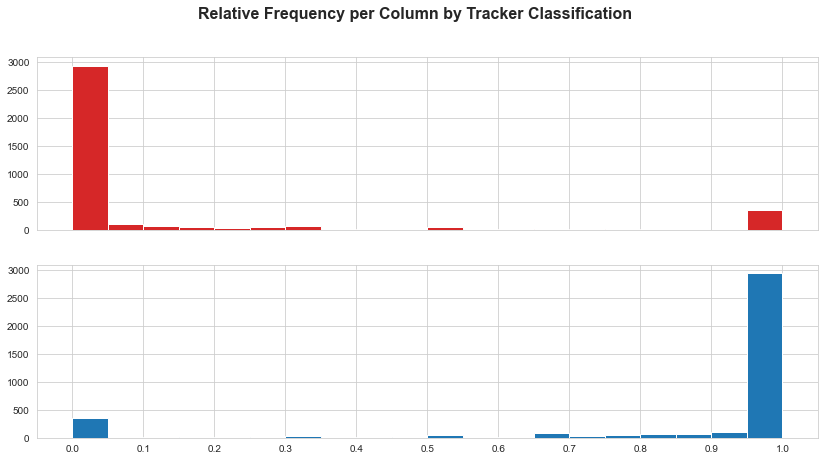

In [577]:
fig, ax = plt.subplots(2, sharex=True, figsize=(14, 7))

ax[0].hist(rel_frequency_per_col.loc[1, :], bins=20, color="tab:red")
ax[1].hist(rel_frequency_per_col.loc[0, :], bins=20)
plt.xticks(np.arange(0, 1.1, 0.1))
fig.suptitle(
    "Relative Frequency per Column by Tracker Classification",
    fontsize=16,
    fontweight="bold",
)

In [568]:
tracker_values = pd.data_firefoxFrame(rel_frequency_per_col.loc[1, :])
tracker_values = tracker_values[tracker_values[1] >= 0.95]
tracker_values.rename(columns={1: "rel_frequency"}, inplace=True)
tracker_values

,rel_frequency
google-lineitem-id,0.996198
google-creative-id,0.996198
google-mediationgroup-id,0.995261
google-mediationtag-id,0.995261
time-delta-millis,1.000000
...,...
x-bcs,1.000000
x-bc-bl,1.000000
x-bcs-o,1.000000
x-o1-bcs-ban,1.000000


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

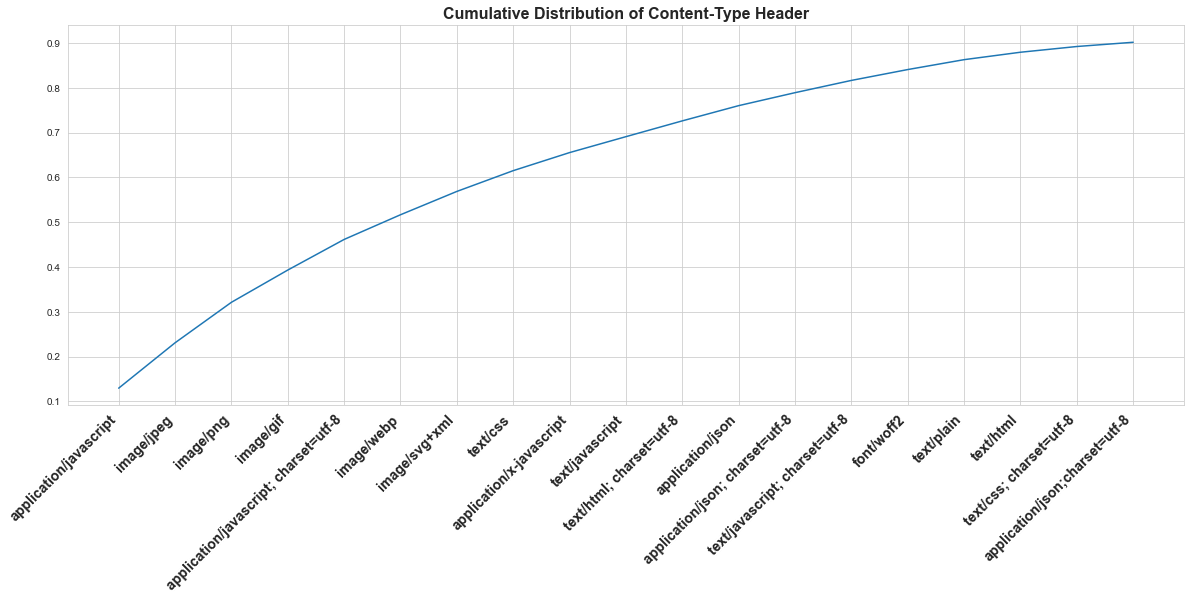

In [22]:
plt.figure(figsize=(20, 7))
plt.plot(
    (
        data_firefox["content-type"].value_counts().cumsum()
        / data_firefox["content-type"].value_counts().sum()
    )[0:19]
)
plt.title(
    "Cumulative Distribution of Content-Type Header", fontsize=16, fontweight="bold"
)
plt.xticks(rotation=45, fontsize=14, fontweight="bold", ha="right")

In [23]:
def create_value_comparison(header_field, n_values):
    header_field_df = pd.DataFrame(
    data_firefox[[f"{header_field}", "tracker"]].value_counts()
        ).reset_index()
    header_field_df.columns = [f"{header_field}", "tracker", "frequency"]
    header_field_df.sort_values(by=["frequency"], ascending=False, inplace=True)

    test_values = header_field_df[0:n_values][f"{header_field}"].values.tolist()
    frequent_content_types = (
        header_field_df[header_field_df[f"{header_field}"].isin(test_values)]
        .reset_index()
        .sort_values(by=f"{header_field}")
    )
    non_tracker = frequent_content_types[frequent_content_types.tracker == 0]
    tracker = frequent_content_types[frequent_content_types.tracker == 1]
    return non_tracker, tracker

In [24]:
def create_value_comparison_plot(non_tracker, tracker, n, header_field):
    r = np.arange(n)
    width = 0.25

    plt.figure(figsize=(20, 7))
    plt.bar(r, non_tracker["frequency"], log=True, label="Non Tracker", width=width)
    plt.bar(r + width, tracker["frequency"], log=True, label="Tracker", width=width)
    plt.xticks(
        r + width / 2,
        non_tracker[f"{header_field}"].values.tolist(),
        rotation=45,
        fontsize=12,
        fontweight="bold",
        ha="right",
    )
    plt.legend()

In [25]:
non_tracker_ct, tracker_ct = create_value_comparison("content-type", 34)
create_value_comparison_plot(non_tracker_ct, tracker_ct, len(tracker_ct))

TypeError: create_value_comparison_plot() missing 1 required positional argument: 'header_field'

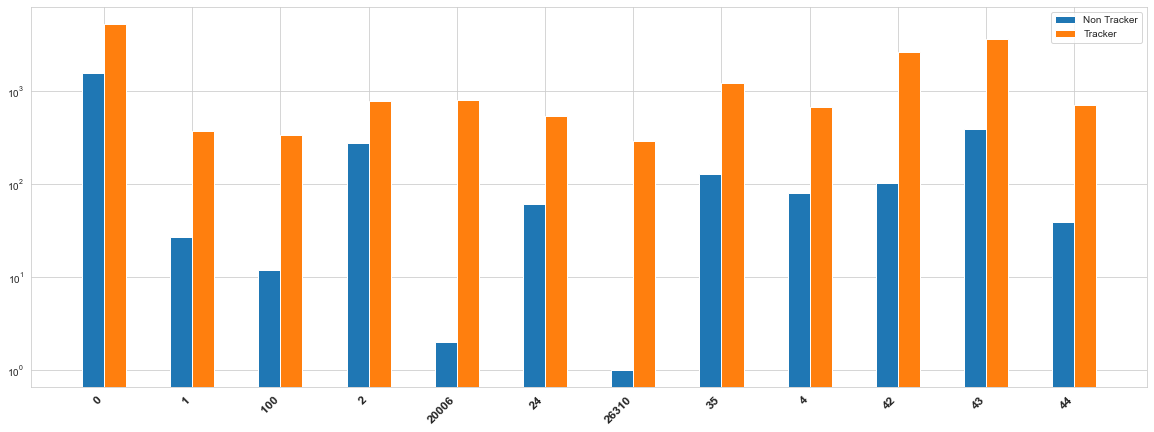

In [105]:
non_tracker_cl, tracker_cl = create_value_comparison("content-length", 14)
create_value_comparison_plot(non_tracker_cl, tracker_cl, len(tracker_cl), 'content-length')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

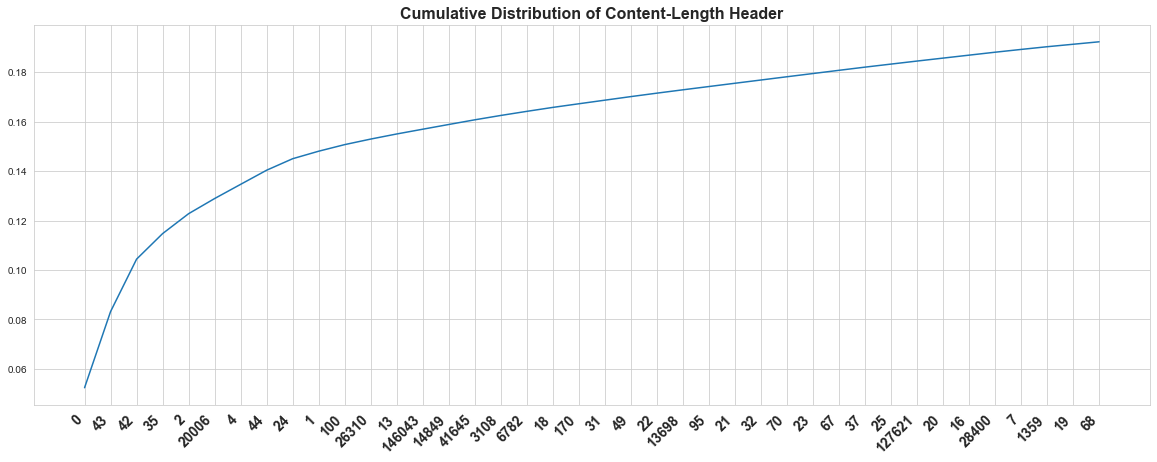

In [143]:
plt.figure(figsize=(20, 7))
plt.plot(
    (
        data_firefox["content-length"].value_counts().cumsum()
        / data_firefox["content-length"].value_counts().sum()
    )[0:40]
)
plt.title(
    "Cumulative Distribution of Content-Length Header", fontsize=16, fontweight="bold"
)
plt.xticks(rotation=45, fontsize=14, fontweight="bold", ha="right")

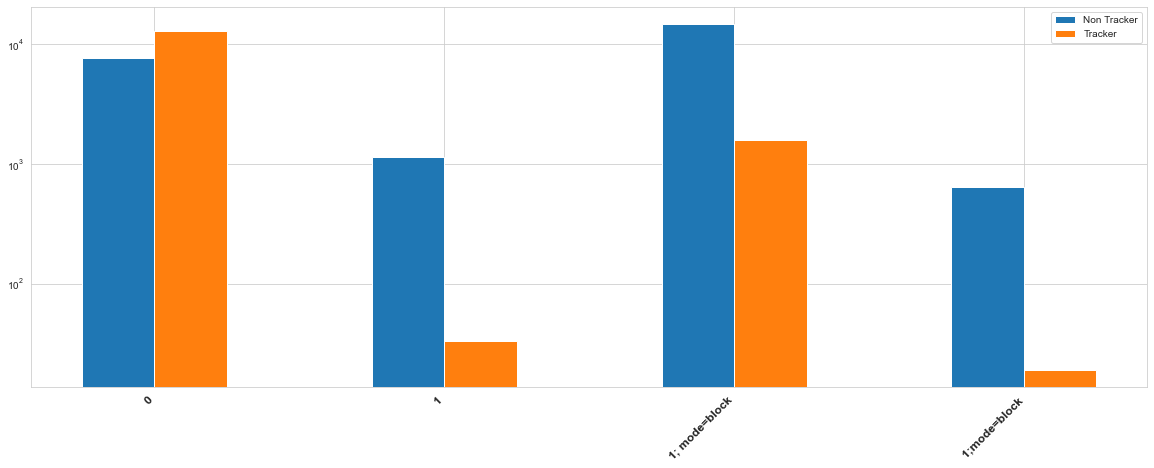

In [27]:
non_tracker_xss, tracker_xss = create_value_comparison("x-xss-protection", 6)
create_value_comparison_plot(non_tracker_xss, tracker_xss, len(tracker_xss), 'x-xss-protection')

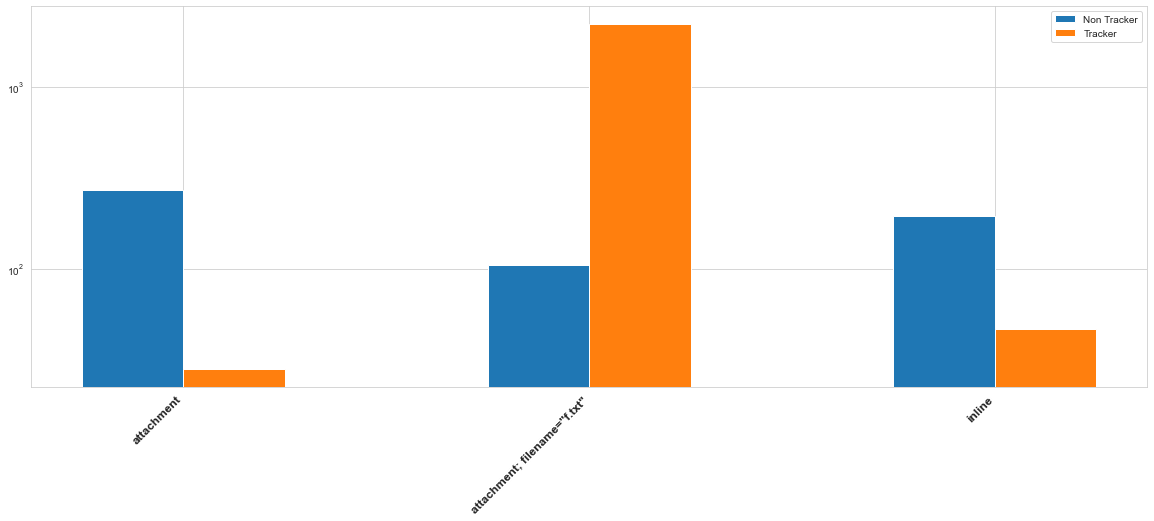

In [29]:
non_tracker_cd, tracker_cd = create_value_comparison("content-disposition", 4)
create_value_comparison_plot(non_tracker_cd, tracker_cd, len(tracker_cd), 'content-disposition')

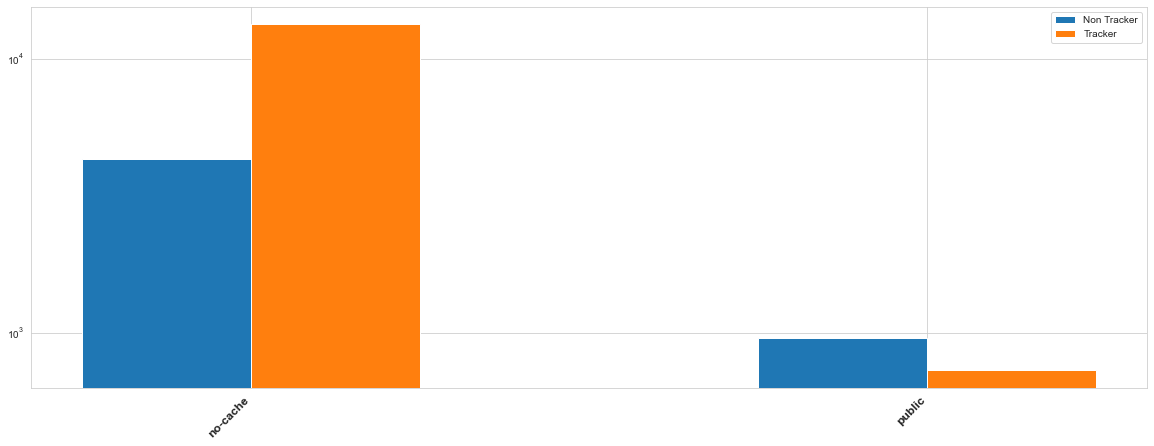

In [28]:
non_tracker_p, tracker_p = create_value_comparison("pragma", 4)
create_value_comparison_plot(non_tracker_p, tracker_p, len(tracker_p), 'pragma')

In [95]:
non_tracker_cl

,index,server,tracker,frequency
2,2,amazons3,0,11006
4,4,apache,0,5094
16,139,cafe,0,83
1,1,cloudflare,0,18901
0,0,nginx,0,21803
9,9,server,0,3464
6,6,sffe,0,3920
7,7,tengine,0,3770


In [96]:
tracker_cl

,index,server,tracker,frequency
12,13,amazons3,1,2046
13,22,apache,1,780
3,3,cafe,1,6459
10,10,cloudflare,1,2518
8,8,golfe2,1,3554
5,5,nginx,1,4081
14,26,server,1,611
11,11,sffe,1,2478
15,62,tengine,1,196


In [97]:
pd.data_firefoxFrame(
    data_firefox[[f"server", "tracker"]].value_counts()
        ).reset_index()

,server,tracker,0
0,nginx,0,21803
1,cloudflare,0,18901
2,amazons3,0,11006
3,cafe,1,6459
4,apache,0,5094
...,...,...,...
1413,mt3 4409 ba5503e master zrh-pixel-x9 config:1.0.0,1,1
1414,mt3 4409 ba5503e master zrh-pixel-x4 config:1.0.0,0,1
1415,mt3 4409 ba5503e master zrh-pixel-x31 config:1...,1,1
1416,mt3 4409 ba5503e master zrh-pixel-x29 config:1...,1,1


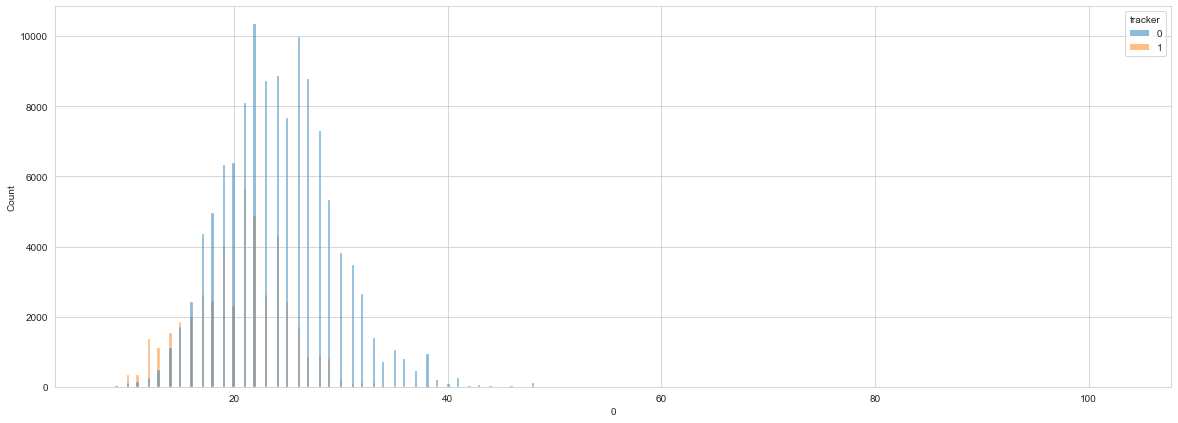

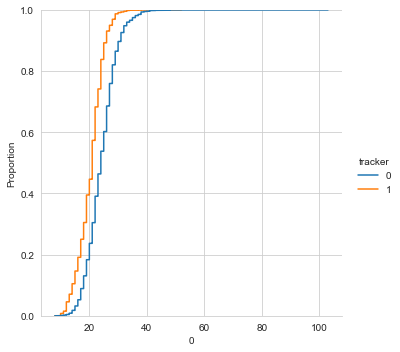

In [30]:
plt.figure(figsize=(20, 7))
# TODO change var name, a bit misleading here
na_per_row = pd.DataFrame((data_firefox.isnull().sum(axis=1) - len(data_firefox.columns))*-1)
na_per_row["tracker"] = data_firefox["tracker"]

sns.histplot(na_per_row, hue='tracker', x=na_per_row.columns.values[0])
sns.displot(na_per_row, hue='tracker', x=na_per_row.columns.values[0], kind='ecdf')

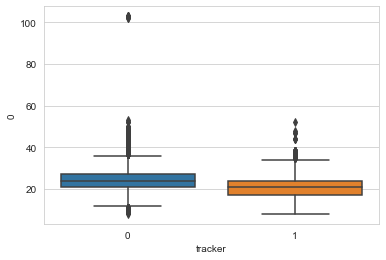

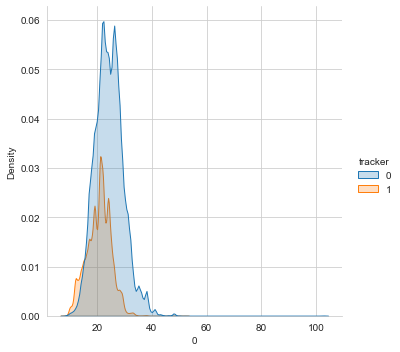

In [32]:
sns.boxplot(data=na_per_row, y=na_per_row.columns.values[0], x='tracker')
sns.displot(na_per_row, hue='tracker', x=na_per_row.columns.values[0], kind='kde', fill=True)

In [371]:
less_ten_headers = data_firefox[((data_firefox.isnull().sum(axis=1) - len(data_firefox.columns))*-1) <= 10].dropna\
    (axis=1,
                                                                                                       how='all')

less_ten_headers

,hostname,pathname,filetype,filename,protocol,query,content-type,cache-control,pragma,date,...,access-control-allow-credentials,x-azure-ref,set-cookie,connection,transfer-encoding,x-amzn-requestid,apigw-requestid,x-33x-status,server-info,tracker
483,js.bd.dhsz.cn,/js/PDPS000000058043.js,js,PDPS000000058043.js,https:,[],text/javascript; charset=utf-8,NaN,NaN,"wed, 18 may 2022 13:15:54 gmt",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
507,js.bd.dhsz.cn,/js/PDPS000000058046.js,js,PDPS000000058046.js,https:,[],text/javascript; charset=utf-8,NaN,NaN,"wed, 18 may 2022 13:15:54 gmt",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
539,js.bd.dhsz.cn,/js/PDPS000000016827.js,js,PDPS000000016827.js,https:,[],text/javascript; charset=utf-8,NaN,NaN,"wed, 18 may 2022 13:15:55 gmt",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
555,js.bd.dhsz.cn,/impress,/impress,impress,https:,"[[p, PDPS000000058043], [u, 1], [pf, baidu], [...",application/json; charset=utf-8,NaN,NaN,"wed, 18 may 2022 13:15:56 gmt",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
557,js.bd.dhsz.cn,/impress,/impress,impress,https:,"[[p, PDPS000000058046], [u, 1], [pf, baidu], [...",application/json; charset=utf-8,NaN,NaN,"wed, 18 may 2022 13:15:56 gmt",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166373,clients1.google.com,/generate_204,/generate_204,generate_204,https:,[],NaN,NaN,NaN,"wed, 18 may 2022 15:05:51 gmt",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
166419,tpc.googlesyndication.com,/generate_204,/generate_204,generate_204,https:,"[[r9S9pg, ]]",NaN,NaN,NaN,"wed, 18 may 2022 15:05:53 gmt",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
167493,tpc.googlesyndication.com,/generate_204,/generate_204,generate_204,https:,"[[iFvV0A, ]]",NaN,NaN,NaN,"wed, 18 may 2022 15:06:22 gmt",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
167509,tpc.googlesyndication.com,/generate_204,/generate_204,generate_204,https:,"[[uc6SIw, ]]",NaN,NaN,NaN,"wed, 18 may 2022 15:06:23 gmt",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [17]:
def variance_per_column(column):
    unique_values = int(len(set(data_firefox[column]))) - 1
    na_values = data_firefox[column].isna().sum()
    rows_with_values = data_firefox[column].value_counts().sum()
    ratio_real_values = round(rows_with_values / unique_values, 3)
    tracker_ratio = data_firefox[data_firefox[column].notnull()].tracker.value_counts()
    try:
        trackers = tracker_ratio[1]
    except KeyError:
        trackers = 0
    try:
        non_trackers = tracker_ratio[0]
    except KeyError:
        non_trackers = 0
    return [column, unique_values, rows_with_values,
            na_values, round(na_values / len(data_firefox), 3), round(rows_with_values / len(data_firefox), 3),
            ratio_real_values, trackers, non_trackers]


def reduced_variance_per_column(column):
    na_values = data_firefox[column].isna().sum()
    return [column, round(na_values / len(data_firefox), 3)]

In [18]:
%%time
number_of_elements = np.array([variance_per_column(column) for column in data_firefox.iloc[:, 6:].columns])

CPU times: user 2min 52s, sys: 18 s, total: 3min 10s
Wall time: 3min 10s


In [19]:
summary_table = pd.data_firefoxFrame(number_of_elements, columns=['header_name', 'unique_values',
                                                          'non_nas', 'nas', 'na_ratio',
                                                          'non_na_ratio', 'ratio_real_values',
                                                          'trackers', 'non_trackers'])

summary_table['unique_values'] = summary_table['unique_values'].astype("Int32")
summary_table['non_nas'] = summary_table['non_nas'].astype("Int32")
summary_table['nas'] = summary_table['nas'].astype("Int32")
summary_table['na_ratio'] = summary_table['na_ratio'].astype("float32")
summary_table['non_na_ratio'] = summary_table['non_na_ratio'].astype("float32")
summary_table['ratio_real_values'] = summary_table['ratio_real_values'].astype("float32")
summary_table['trackers'] = summary_table['trackers'].astype("Int32")
summary_table['non_trackers'] = summary_table['non_trackers'].astype("Int32")

summary_table.sort_values(by='ratio_real_values', ascending=False, inplace=True)
summary_table.reset_index(drop=True, inplace=True)
summary_table.drop([0], inplace=True)
summary_table.reset_index(drop=True, inplace=True)
summary_table

,header_name,unique_values,non_nas,nas,na_ratio,non_na_ratio,ratio_real_values,trackers,non_trackers
0,accept-ranges,2,109785,68047,0.383,0.617,54892.500000,238,109547
1,content-encoding,8,85150,92682,0.521,0.479,10643.750000,602,84548
2,x-content-type-options,6,53561,124271,0.699,0.301,8926.833008,494,53067
3,connection,4,18991,158841,0.893,0.107,4747.750000,147,18844
4,x-amz-server-side-encryption,2,6579,171253,0.963,0.037,3289.500000,4,6575
...,...,...,...,...,...,...,...,...,...
3726,x-variti-ccr,94,94,177738,0.999,0.001,1.000000,0,94
3727,x-rs-ben-time,1,1,177831,1.000,0.000,1.000000,0,1
3728,x-rs-time,2,2,177830,1.000,0.000,1.000000,0,2
3729,sprequestguid,96,96,177736,0.999,0.001,1.000000,0,96


In [20]:
remove_headers_with_one_na_ratio = summary_table[summary_table['na_ratio'] == 1].header_name.values.tolist()

data_firefox.drop(remove_headers_with_one_na_ratio, axis=1, inplace=True)

['transfer-encoding',
 'x-ms-lease-status',
 'x-download-options',
 'unused62',
 'x-check-cacheable',
 'x-fb-rlafr',
 'wadp-version',
 'country',
 'content-transfer-encoding',
 'x-cos-object-type',
 'cf-cdnjs-via',
 'cdn-requestpullsuccess',
 'cdn-status',
 'xcs',
 'x-akamai-http2-push',
 'x-ftr-realm',
 'x-hcs-proxy-type',
 'x-turbo-charged-by',
 'x-akamai-im-skip-dlr',
 'x-browser',
 'picasso-ret-code',
 'x-browser-version',
 'x-ecma-v',
 'rating',
 'x-magnolia-registration',
 'x-gateway-skip-cache',
 'cloudservicediscount',
 'x-ebay-c-version',
 'x-defhash',
 'fastly-io-warning',
 'ki-edge',
 'x-image-server-product',
 'x-forwarded-https',
 'x-gdpr',
 'x-ingrpoll-id',
 'x-nyt-app-webview',
 'x-geoip-region-code',
 'quic-version',
 'x-svc-name',
 'x-svc-version',
 'x-svc-env',
 'x-svc-go-version',
 'normalized-language',
 'arr-disable-session-affinity',
 'x-hs-https-only',
 'x-wbx-about',
 'x-reserved',
 'filename1',
 'fastly-restarts',
 'x-ms-invokeapp',
 'x-http2-push',
 'x-resizer

In [27]:
remove_headers_with_one_value = summary_table[
    (summary_table['unique_values'] <= 1) & (summary_table['na_ratio'] != 1)].header_name.values.tolist()
data_firefox.drop(remove_headers_with_one_value, axis=1, inplace=True)

KeyError: "['transfer-encoding', 'x-ms-lease-status', 'x-download-options', 'unused62', 'x-check-cacheable', 'x-fb-rlafr', 'wadp-version', 'country', 'content-transfer-encoding', 'x-cos-object-type', 'cf-cdnjs-via', 'cdn-requestpullsuccess', 'cdn-status', 'xcs', 'x-akamai-http2-push', 'x-ftr-realm', 'x-hcs-proxy-type', 'x-turbo-charged-by', 'x-akamai-im-skip-dlr', 'x-browser', 'picasso-ret-code', 'x-browser-version', 'x-ecma-v', 'rating', 'x-magnolia-registration', 'x-gateway-skip-cache', 'cloudservicediscount', 'x-ebay-c-version', 'x-defhash', 'fastly-io-warning', 'ki-edge', 'x-image-server-product', 'x-forwarded-https', 'x-gdpr', 'x-ingrpoll-id', 'x-nyt-app-webview', 'x-geoip-region-code', 'quic-version', 'x-svc-name', 'x-svc-version', 'x-svc-env', 'x-svc-go-version', 'normalized-language', 'arr-disable-session-affinity', 'x-hs-https-only', 'x-wbx-about', 'x-reserved', 'filename1', 'fastly-restarts', 'x-ms-invokeapp', 'x-http2-push', 'x-resizerversion', 'bfcache-opt-in', 'x-source-scheme', 'x-ihr-app-language', 'x-whitelisted', 'twc-device-class', 'x-pics-origin', 'mime-version', 'x-instana-l', 'twc-locale-group', 'twc-connection-speed', 'twc-geoip-latlong', 'twc-geoip-dma', 'twc-privacy', 'x-alicdn-tsign-info', 'x-httpd', 'viewport', 'x-bce-restore-cache', 'x-fw-version', 'x-fw-type', 'x-fw-serve', 'cleartype', 'x-requester', 'x-cms-platform', 'x-cms-developed-by', 'x-theme-asset', 'x-debug-info', 'cdncip', 'x-cache-backend', 'fastly-io-error', 'origin-branch', 'x-fazpay-content', 'server-info', 'x-dfis-file-ttl', 'x-dfis-file-active', 'x-endurance-cache-level', 'x-nginx-cache', 'x-forwarded-proto', 'alternate-protocol', 'x-cdn-node', 'x-cdn-forward', 'twc-path-locale', 'twc-unit', 'twc-subs', 'x-esi-enable', 'x-amz-meta-index-tag', 'code', 'sepia-upstream', 'x-response-lb', 'x-77-cache', 'x-vice-split-testing', 'tls_version', 'cdn-host', 'x-thumbnailer', 'x-ve-ac', 'client.geo.latitude', 'client.geo.postal_code', 'client.geo.longitude', 'x-ihr-app-country', 'ld-region', 'x-rtflag', 'x-smartersafe-version', 'x-cs-bucket', 'x-cache-bucket'] not found in axis"

In [31]:
data_firefox = data_firefox[~data_firefox.duplicated(keep='first')].reset_index(drop=True)

TypeError: unhashable type: 'numpy.ndarray'

In [42]:
data_firefox

,hostname,pathname,filetype,filename,protocol,date,expires,cache-control,content-type,strict-transport-security,...,x-alicdn-via,x-varnish-director,x-vg-webcache,x-vg-tlsproxy,x-vg-webserver,cpc-age,x-tr-request-id,remaining_edge_ttl,q,tracker
0,www.google.com,/,/,,https:,"fri, 12 aug 2022 09:19:05 gmt",-1,"private, max-age=0",text/html; charset=utf-8,max-age=31536000,...,None,None,None,None,None,None,None,None,None,0
1,www.youtube.com,/,/,,https:,"fri, 12 aug 2022 09:19:05 gmt","mon, 01 jan 1990 00:00:00 gmt","no-cache, no-store, max-age=0, must-revalidate",text/html; charset=utf-8,max-age=31536000,...,None,None,None,None,None,None,None,None,None,0
2,www.instagram.com,/,/,,https:,"fri, 12 aug 2022 09:19:05 gmt","sat, 01 jan 2000 00:00:00 gmt","private, no-cache, no-store, must-revalidate",text/html; charset=utf-8,max-age=31536000,...,None,None,None,None,None,None,None,None,None,0
3,www.facebook.com,/,/,,https:,"fri, 12 aug 2022 09:19:05 gmt","sat, 01 jan 2000 00:00:00 gmt","private, no-cache, no-store, must-revalidate","text/html; charset=""utf-8""",max-age=15552000; preload,...,None,None,None,None,None,None,None,None,None,0
4,twitter.com,/,/,,https:,"fri, 12 aug 2022 09:19:05 gmt",None,"no-cache, no-store, must-revalidate, pre-check...",text/html; charset=utf-8,max-age=631138519,...,None,None,None,None,None,None,None,None,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177827,media.gamestop.com,/i/gamestop/Back2SchoolCTA_1440x200_FullBlade_...,webp,Back2SchoolCTA_1440x200_FullBlade_D.webp,https:,"fri, 12 aug 2022 12:50:46 gmt",None,"s-maxage=86400, max-age=1800",image/webp,None,...,None,None,None,None,None,None,None,None,None,0
177828,www.thinkwithgoogle.com,/,/,,https:,"fri, 12 aug 2022 12:50:53 gmt",None,private,text/html; charset=utf-8,max-age=31536000,...,None,None,None,None,None,None,None,None,None,0
177829,www.thinkwithgoogle.com,/_qs/static/dist/css/homepage.461c4d7b12ff37be...,css,homepage.461c4d7b12ff37bebf70.css,https:,"fri, 29 jul 2022 00:53:09 gmt","sat, 29 jul 2023 00:53:09 gmt","public, max-age=31536000",text/css,None,...,None,None,None,None,None,None,None,None,None,0
177830,www.thinkwithgoogle.com,/_qs/static/dist/css/main.18242affa600e7755022...,css,main.18242affa600e7755022.css,https:,"fri, 29 jul 2022 00:30:20 gmt","sat, 29 jul 2023 00:30:20 gmt","public, max-age=31536000",text/css,None,...,None,None,None,None,None,None,None,None,None,0


In [35]:
def test222(element):
    if element in ['x-nws-log-uuid', 'traceid', 'x-oss-hash-crc64ecma',
                   'x-neory-subid', 'gsid', 'cdn-request-id', 'dd.trace_id',
                   'x-amz-meta-cld-surrogate-key', 'dd-trace-id',
                   'x-fc-code-checksum', 'tracecode', 'x-cos-hash-crc64ecma']:
        return None
    try:
        data_firefox[element].sample(40000, random_state=10).astype('Int64')
        return {element: "Int64"}
    except ValueError:
        pass

In [44]:
%%time
columns_as_category = {i: 'category' for i in data_firefox.columns.values[:-1]}
braze2 = data_firefox.iloc[:, 6:].swifter.apply(lambda x: test222(x.name))
braze2 = list(filter(lambda x: type(x) is dict, braze2.values.tolist()))
braze2 = {k: v for d in braze2 for k, v in d.items()}

Pandas Apply:   0%|          | 0/537 [00:00<?, ?it/s]

CPU times: user 11.7 s, sys: 220 ms, total: 11.9 s
Wall time: 11.9 s


In [ ]:
columns_as_category.update(braze2)
data_firefox.drop('query', axis=1, inplace=True)

In [49]:
data_firefox = data_firefox.astype(columns_as_category)

ValueError: invalid literal for int() with base 10: 'null'

In [48]:
columns_as_category

{'hostname': 'category',
 'pathname': 'category',
 'filetype': 'category',
 'filename': 'category',
 'protocol': 'category',
 'date': 'category',
 'expires': 'category',
 'cache-control': 'category',
 'content-type': 'category',
 'strict-transport-security': 'category',
 'accept-ch': 'category',
 'p3p': 'category',
 'content-encoding': 'category',
 'server': 'category',
 'content-length': 'Int64',
 'x-xss-protection': 'category',
 'x-frame-options': 'category',
 'set-cookie': 'category',
 'alt-svc': 'category',
 'x-content-type-options': 'category',
 'pragma': 'category',
 'permissions-policy': 'category',
 'vary': 'category',
 'report-to': 'category',
 'cross-origin-opener-policy-report-only': 'category',
 'content-language': 'category',
 'content-security-policy': 'category',
 'cross-origin-opener-policy': 'category',
 'access-control-expose-headers': 'category',
 'x-fb-trip-id': 'Int64',
 'document-policy': 'category',
 'content-security-policy-report-only': 'category',
 'x-fb-debug